<a href="https://colab.research.google.com/github/chomchom69420/bayesian-nn/blob/master/mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
import torch
import torch.nn as nn
import torchbnn as bnn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

%matplotlib inline

In [21]:
print(torch.cuda.is_available())

True


In [23]:
# Convert MNIST images into 4D tensors (#images, height, width, color channel)

transform = transforms.ToTensor()

In [24]:
# Create training data
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

In [25]:
# Create test data
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

In [26]:
# Params
filter = True
if filter:
    filtered_class = 5

load_model = True

In [65]:
# Remove the class 5 from the data
if filter:
    filtered_indices = [i for i, (_,label) in enumerate(train_data) if label!=5]
    train_data_filtered = torch.utils.data.Subset(train_data, filtered_indices)
else:
    train_data_filtered = train_data

In [66]:
# Create small batch size for images
train_loader = DataLoader(train_data_filtered, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

In [29]:
#Define the Model class
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()

        # Bayesian Convolutional Layers
        self.conv1 = bnn.BayesConv2d(prior_mu=0, prior_sigma=0.1, in_channels=1, out_channels=6, kernel_size=3, stride=1)
        self.conv2 = bnn.BayesConv2d(prior_mu=0, prior_sigma=0.1, in_channels=6, out_channels=16, kernel_size=3, stride=1)

        # Bayesian Fully Connected Layers
        self.fc1 = bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=16*5*5, out_features=120)      #16 filters, 5x5 size of each output "image" in the conv2 layer
        self.fc2 = bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=120, out_features=84)
        self.fc3 = bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=84, out_features=10)

    def forward(self, X):
        # Pass through convolutional and pooling layers with ReLU activation
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2,2)  #kernel = 2x2, stride = 2
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X,2,2)

        # Flatten out the data
        X = X.view(-1, 16*5*5)      # -1 so that we can vary the batch size

        # Pass through the fully connected layers
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)

        return F.log_softmax(X, dim=1)


In [30]:
# Create an instance of the model
torch.manual_seed(41)
model = ConvolutionalNetwork()

In [31]:
# Move the model to the cuda device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

ConvolutionalNetwork(
  (conv1): BayesConv2d(0, 0.1, 1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): BayesConv2d(0, 0.1, 6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=400, out_features=120, bias=True)
  (fc2): BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=120, out_features=84, bias=True)
  (fc3): BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=84, out_features=10, bias=True)
)

In [32]:
# Select loss function and optimizer
ce_loss = nn.CrossEntropyLoss()
kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False)
kl_weight=0.1
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [35]:
# Variables to track losses
epochs = 5

if load_model:
    model.load_state_dict(torch.load('mnist_bnn.pt'))

else:
    #For loop over epochs
    for i in range(epochs):
        trn_corr = 0
        tst_corr = 0

        #Train
        for b, (X_train, y_train) in enumerate(train_loader):
            b+=1                                            #Start the batch at 1

            # Move the data and labels to the cuda device, if available
            X_train, y_train = X_train.to(device), y_train.to(device)

            # Forward pass
            y_pred = model(X_train)
            ce = ce_loss(y_pred, y_train)
            kl = kl_loss(model)
            loss = ce+ kl*kl_weight

            # Backward pass - update parameters
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            #Print out some results
            if b%600==0:
                print(f"Epoch = {i} Batch = {b} Loss = {loss.item()}")
                print(f"Allocated memory: {torch.cuda.memory_allocated() / 1024**2} MB")
                print(f"Cached memory: {torch.cuda.memory_reserved() / 1024**2} MB")

    # Save the model after training
    torch.save(model.state_dict(), 'mnist_bnn.pt')

    X_test = torch.stack([data[0] for data in train_data])
    y_test = torch.LongTensor([data[1] for data in train_data])

    _, predicted = torch.max(model(X_train).data, 1)
    total = y_train.size(0)
    correct = (predicted == y_train).sum()
    print('- Accuracy: %f %%' % (100 * float(correct) / total))
    print('- CE : %2.2f, KL : %2.2f' % (ce.item(), kl.item()))

Epoch = 0 Batch = 600 Loss = 0.24118585884571075
Allocated memory: 18.169921875 MB
Cached memory: 26.0 MB
Epoch = 0 Batch = 1200 Loss = 0.6067807674407959
Allocated memory: 18.169921875 MB
Cached memory: 26.0 MB
Epoch = 0 Batch = 1800 Loss = 0.3992709219455719
Allocated memory: 18.169921875 MB
Cached memory: 26.0 MB
Epoch = 0 Batch = 2400 Loss = 0.15570957958698273
Allocated memory: 18.169921875 MB
Cached memory: 26.0 MB
Epoch = 0 Batch = 3000 Loss = 0.7966600060462952
Allocated memory: 18.169921875 MB
Cached memory: 26.0 MB
Epoch = 0 Batch = 3600 Loss = 0.14562556147575378
Allocated memory: 18.169921875 MB
Cached memory: 26.0 MB
Epoch = 0 Batch = 4200 Loss = 0.5586368441581726
Allocated memory: 18.169921875 MB
Cached memory: 26.0 MB
Epoch = 0 Batch = 4800 Loss = 0.19034206867218018
Allocated memory: 18.169921875 MB
Cached memory: 26.0 MB
Epoch = 0 Batch = 5400 Loss = 0.15609468519687653
Allocated memory: 18.169921875 MB
Cached memory: 26.0 MB
Epoch = 1 Batch = 600 Loss = 0.60225737094

In [37]:
#Test
tst_corr = 0

with torch.no_grad():
    for b, (X_test, y_test) in enumerate(test_loader):
        X_test, y_test = X_test.to(device), y_test.to(device)
        y_val = model(X_test)
        predicted = torch.max(y_val.data, 1)[1]
        batch_corr = (predicted == y_test).sum()
        tst_corr += batch_corr

print(f"Test accuracy : {(tst_corr/10000)*100} %")

Test accuracy : 88.08999633789062 %


In [38]:
X_test = torch.stack([data[0] for data in test_data])
y_test = torch.LongTensor([data[1] for data in test_data])

In [40]:
torch.argwhere(y_test==5).T

tensor([[   8,   15,   23,   45,   52,   53,   59,  102,  120,  127,  129,  132,
          152,  153,  155,  162,  165,  167,  182,  187,  207,  211,  218,  219,
          240,  253,  261,  283,  289,  317,  319,  333,  340,  347,  351,  352,
          356,  364,  367,  375,  395,  397,  406,  412,  433,  460,  469,  478,
          483,  491,  502,  509,  518,  540,  570,  588,  604,  618,  638,  645,
          654,  674,  692,  694,  710,  711,  720,  739,  751,  766,  778,  779,
          785,  791,  797,  812,  856,  857,  866,  869,  897,  934,  935,  951,
          955,  970,  978, 1003, 1022, 1032, 1041, 1046, 1070, 1073, 1082, 1087,
         1089, 1102, 1113, 1115, 1131, 1135, 1144, 1146, 1168, 1169, 1190, 1221,
         1233, 1235, 1243, 1252, 1258, 1272, 1281, 1285, 1289, 1299, 1331, 1334,
         1339, 1340, 1370, 1376, 1378, 1393, 1405, 1406, 1421, 1447, 1460, 1466,
         1467, 1471, 1473, 1476, 1493, 1510, 1521, 1525, 1550, 1598, 1618, 1629,
         1635, 1637, 1639, 1

In [42]:
n_models = 100
X_test = X_test.to(device)
models_result = [model(X_test[3115]) for k in range(n_models)]

In [48]:
models_result[0].argmax().item()

3

In [49]:
results = np.zeros(n_models)
for i in range(n_models):
  results[i] = models_result[i].argmax().item()

In [50]:
results

array([3., 9., 3., 3., 3., 3., 9., 9., 3., 9., 9., 9., 9., 3., 9., 9., 9.,
       3., 9., 9., 3., 3., 9., 9., 9., 9., 9., 3., 9., 3., 9., 9., 3., 3.,
       9., 9., 3., 3., 9., 9., 3., 9., 3., 9., 3., 9., 9., 9., 3., 3., 9.,
       9., 9., 9., 9., 3., 9., 3., 3., 3., 3., 9., 3., 9., 9., 3., 9., 3.,
       3., 9., 9., 3., 9., 9., 9., 9., 3., 9., 3., 9., 9., 3., 9., 3., 9.,
       9., 3., 9., 9., 9., 3., 9., 3., 9., 9., 3., 9., 9., 9., 3.])

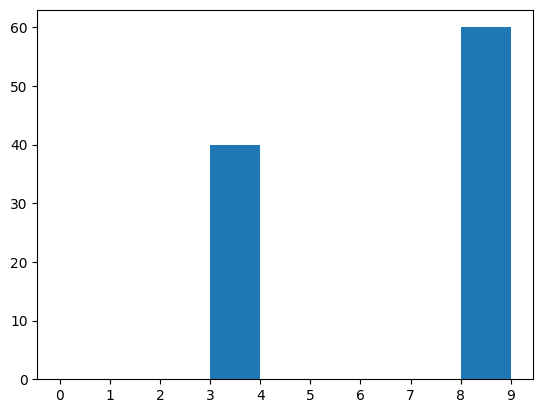

In [63]:
plt.hist(results, bins=[0,1,2,3,4,5,6,7,8,9], align='mid')
plt.xticks([0,1,2,3,4,5,6,7,8,9], ha='center')
plt.show()

In [89]:
# Create slice of test dataset that contains only the filteredClass
if filter:
    filtered_indices = [i for i, (_,label) in enumerate(test_data) if label==5]
    test_data_filtered_unseen = torch.utils.data.Subset(test_data, filtered_indices)

In [71]:
test_data_filtered_unseen

In [88]:
test_filt_loader = DataLoader(test_data_filtered_unseen, batch_size = len(test_data_filtered_unseen))

images, labels = next(iter(test_filt_loader))
images, labels = images.to(device), labels.to(device)

In [91]:
samples = torch.zeros((n_models, len(test_data_filtered_unseen), 10))

for i in range(n_models) :
  print("\r", "\tTest run {}/{}".format(i+1, n_models), end="")

  samples[i,:,:] = torch.exp(model(images))

 	Test run 1/100

RuntimeError: The expanded size of the tensor (892) must match the existing size (1032) at non-singleton dimension 0.  Target sizes: [892, 10].  Tensor sizes: [1032, 10]

In [81]:
withinSampleMean = torch.mean(samples, dim=0)
samplesMean = torch.mean(samples, dim=(0,1))

withinSampleStd = torch.sqrt(torch.mean(torch.var(samples, dim=0), dim=0))
acrossSamplesStd = torch.std(withinSampleMean, dim=0)

print("")
print("Class prediction analysis:")
print("\tMean class probabilities:")
print(samplesMean)
print("\tPrediction standard deviation per sample:")
print(withinSampleStd)
print("\tPrediction standard deviation across samples:")
print(acrossSamplesStd)


Class prediction analysis:
	Mean class probabilities:
tensor([0.0320, 0.0422, 0.0144, 0.2814, 0.0420, 0.0010, 0.0691, 0.0131, 0.3674,
        0.1375], grad_fn=<MeanBackward1>)
	Prediction standard deviation per sample:
tensor([0.0367, 0.0353, 0.0122, 0.0760, 0.0326, 0.0010, 0.0526, 0.0129, 0.0813,
        0.0530], grad_fn=<SqrtBackward0>)
	Prediction standard deviation across samples:
tensor([0.1022, 0.1386, 0.0227, 0.3617, 0.1260, 0.0020, 0.1945, 0.0568, 0.3720,
        0.2364], grad_fn=<StdBackward0>)


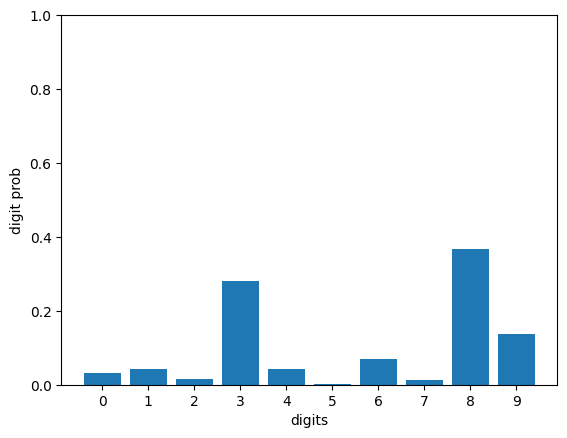

In [85]:
plt.figure("Unseen class probabilities")
plt.bar(np.arange(10), samplesMean.detach().numpy())
plt.xlabel('digits')
plt.ylabel('digit prob')
plt.ylim([0,1])
plt.xticks(np.arange(10))
plt.show()

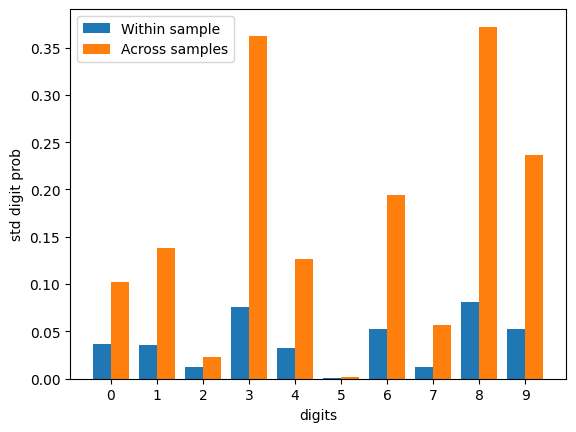

In [87]:
plt.figure("Unseen inner and outter sample std")
plt.bar(np.arange(10)-0.2, withinSampleStd.detach().numpy(), width = 0.4, label="Within sample")
plt.bar(np.arange(10)+0.2, acrossSamplesStd.detach().numpy(), width = 0.4, label="Across samples")
plt.legend()
plt.xlabel('digits')
plt.ylabel('std digit prob')
plt.xticks(np.arange(10))
plt.show()

## Testing against seen class

In [90]:
# Create slice of test dataset that contains only the seen class (here, say 2)

filtered_indices = [i for i, (_,label) in enumerate(test_data) if label==2]
test_data_filtered_seen = torch.utils.data.Subset(test_data, filtered_indices)

test_filt_loader = DataLoader(test_data_filtered_seen, batch_size = len(test_data_filtered_seen))

images, labels = next(iter(test_filt_loader))
images, labels = images.to(device), labels.to(device)

In [92]:
samples = torch.zeros((n_models, len(test_data_filtered_seen), 10))

for i in range(n_models) :
  print("\r", "\tTest run {}/{}".format(i+1, n_models), end="")

  samples[i,:,:] = torch.exp(model(images))

 	Test run 100/100

In [93]:
withinSampleMean = torch.mean(samples, dim=0)
samplesMean = torch.mean(samples, dim=(0,1))

withinSampleStd = torch.sqrt(torch.mean(torch.var(samples, dim=0), dim=0))
acrossSamplesStd = torch.std(withinSampleMean, dim=0)

print("")
print("Class prediction analysis:")
print("\tMean class probabilities:")
print(samplesMean)
print("\tPrediction standard deviation per sample:")
print(withinSampleStd)
print("\tPrediction standard deviation across samples:")
print(acrossSamplesStd)


Class prediction analysis:
	Mean class probabilities:
tensor([3.7897e-03, 9.6894e-03, 9.4795e-01, 4.8016e-03, 3.0841e-03, 1.4895e-04,
        2.9987e-03, 1.1763e-02, 1.3214e-02, 2.5628e-03],
       grad_fn=<MeanBackward1>)
	Prediction standard deviation per sample:
tensor([0.0162, 0.0198, 0.0440, 0.0119, 0.0093, 0.0003, 0.0097, 0.0199, 0.0234,
        0.0086], grad_fn=<SqrtBackward0>)
	Prediction standard deviation across samples:
tensor([0.0353, 0.0533, 0.1717, 0.0288, 0.0191, 0.0006, 0.0414, 0.0744, 0.0812,
        0.0287], grad_fn=<StdBackward0>)


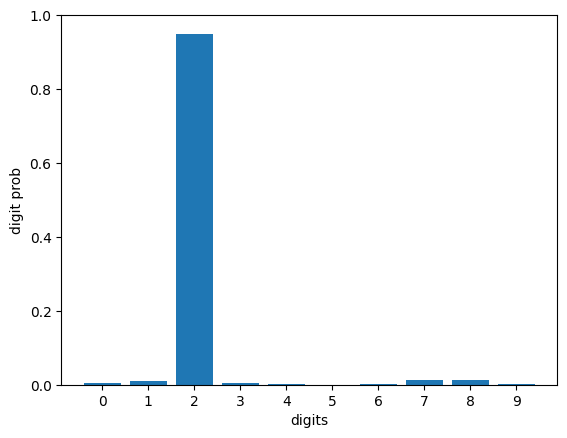

In [94]:
plt.figure("Seen class probabilities")
plt.bar(np.arange(10), samplesMean.detach().numpy())
plt.xlabel('digits')
plt.ylabel('digit prob')
plt.ylim([0,1])
plt.xticks(np.arange(10))
plt.show()

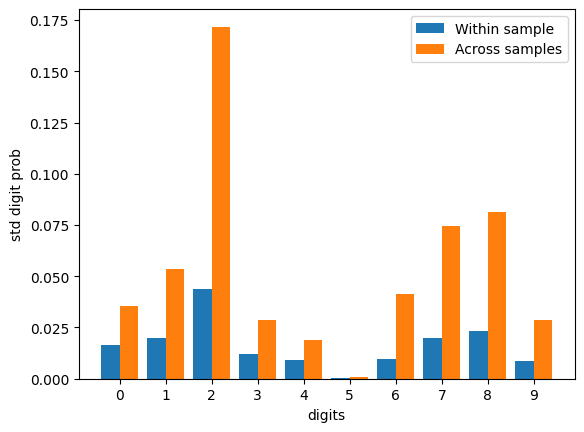

In [95]:
plt.figure("Seen inner and outter sample std")
plt.bar(np.arange(10)-0.2, withinSampleStd.detach().numpy(), width = 0.4, label="Within sample")
plt.bar(np.arange(10)+0.2, acrossSamplesStd.detach().numpy(), width = 0.4, label="Across samples")
plt.legend()
plt.xlabel('digits')
plt.ylabel('std digit prob')
plt.xticks(np.arange(10))
plt.show()